<a href="https://colab.research.google.com/github/hust89/-Hust-simulator/blob/main/Colab_scaffpld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab prerequisites (run once)
# SciPy, NumPy, Matplotlib are available on Colab; this installs nothing heavy but ensures up-to-date libs.
import sys
!pip install --quiet numpy scipy matplotlib
print("Ready: numpy, scipy, matplotlib")

Ready: numpy, scipy, matplotlib


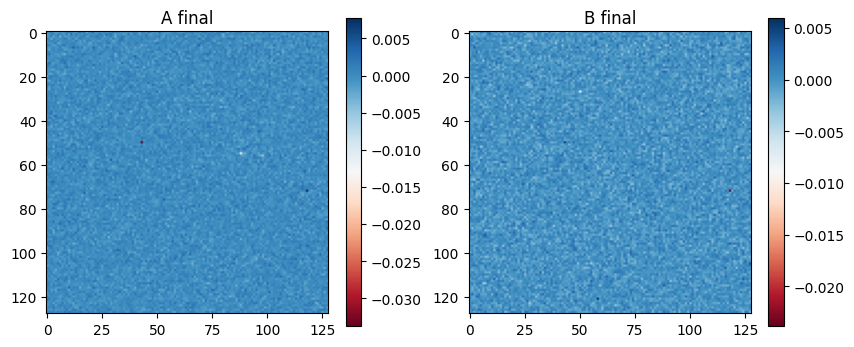

Final energy: 0.052958001266822916
Final entropy: 3335.1649340309723
Final free-energy: -3335.1119760297056
Wrote motif_demo_result.json with SHA: f2b7a0e88e2c56b9ebad22d886291962aa8701e716f3de43fa1448bb53f0d099


In [2]:
# Motif engine + simulated annealing sampler (Colab-ready)
# Copy this entire cell into Colab and run. It defines the numeric engine, demo runner, batch runner, and ledger output.

import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt
import json, hashlib, time
from typing import Tuple, Callable

# ----------------------------
# Parameters (tune these)
# ----------------------------
nx, ny = 128, 128             # grid
alpha = 1.0                   # gradient energy weight
c1, c2, c3, c4 = 1.0, 1.0, 0.0, 1.0  # potential coefficients
beta = 1.0                    # entropy proxy weight
T0 = 1.0                      # initial temperature-like parameter
anneal_steps = 2000           # total metropolis steps
save_every = 200              # trace snapshot interval
step_scale = 1e-2             # proposal step scale

# ----------------------------
# Utility functions
# ----------------------------
def potential(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    """Quartic coupled potential (elementwise)."""
    return c1 * A**2 + c2 * B**2 + c3 * A * B + c4 * (A**4 + B**4)

def grad_sq(field: np.ndarray) -> np.ndarray:
    gx = np.gradient(field, axis=0)
    gy = np.gradient(field, axis=1)
    return gx**2 + gy**2

def energy_density(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    return 0.5 * alpha * (grad_sq(A) + grad_sq(B)) + potential(A, B)

def total_energy(A: np.ndarray, B: np.ndarray) -> float:
    return float(np.sum(energy_density(A, B)))

def entropy_density(A: np.ndarray, B: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    # shift to positive domain for entropy proxy
    Ap = A - A.min() + eps
    Bp = B - B.min() + eps
    Sd = -(Ap * np.log(Ap) + Bp * np.log(Bp))
    return Sd

def total_entropy(A: np.ndarray, B: np.ndarray) -> float:
    return float(np.sum(entropy_density(A, B)))

def free_energy(A: np.ndarray, B: np.ndarray, T: float = T0) -> float:
    return total_energy(A, B) - T * total_entropy(A, B)

# ----------------------------
# Initialization
# ----------------------------
def init_motifs(mode: str = 'rand', scale: float = 1e-3) -> Tuple[np.ndarray, np.ndarray]:
    if mode == 'rand':
        A = scale * np.random.randn(nx, ny)
        B = scale * np.random.randn(nx, ny)
    elif mode == 'spot':
        A = np.zeros((nx, ny)); B = np.zeros((nx, ny))
        cx, cy = nx//2, ny//2
        A[cx-4:cx+4, cy-4:cy+4] = 1.0
    else:
        raise ValueError("Unknown init mode")
    return A, B

# ----------------------------
# Proposal operator
# ----------------------------
def propose_step(A: np.ndarray, B: np.ndarray, step_scale: float = step_scale) -> Tuple[np.ndarray, np.ndarray, tuple]:
    i = np.random.randint(0, nx); j = np.random.randint(0, ny)
    dA = step_scale * np.random.randn()
    dB = step_scale * np.random.randn()
    A_new = A.copy(); B_new = B.copy()
    A_new[i, j] += dA; B_new[i, j] += dB
    return A_new, B_new, (i, j, dA, dB)

# ----------------------------
# Simulated annealing (Metropolis)
# ----------------------------
def anneal(A: np.ndarray, B: np.ndarray, steps: int = anneal_steps, T_init: float = T0,
           cooling: str = 'exp', step_scale_loc: float = step_scale, save_every_loc: int = save_every):
    T = T_init
    trace = []
    E = free_energy(A, B, T=T)
    for k in range(steps):
        A_prop, B_prop, meta = propose_step(A, B, step_scale=step_scale_loc)
        E_prop = free_energy(A_prop, B_prop, T=T)
        dE = E_prop - E
        accept = False
        if dE <= 0:
            accept = True
        else:
            p = np.exp(-dE / max(T, 1e-12))
            if np.random.rand() < p:
                accept = True
        if accept:
            A, B, E = A_prop, B_prop, E_prop
        # cooling schedule
        if cooling == 'exp':
            T = T_init * (0.995 ** k)
        elif cooling == 'linear':
            T = max(1e-6, T_init * (1 - k/steps))
        if (k % save_every_loc == 0) or (k == steps - 1):
            trace.append({'step': k, 'T': float(T), 'E': float(E)})
    return A, B, trace

# ----------------------------
# Batch runner and ledger
# ----------------------------
def run_batch(artifact_loader: Callable[[], Tuple[np.ndarray, np.ndarray]], n_runs: int = 1):
    results = []
    for r in range(n_runs):
        A, B = artifact_loader()
        A_fin, B_fin, trace = anneal(A, B)
        final_energy = total_energy(A_fin, B_fin)
        final_entropy = total_entropy(A_fin, B_fin)
        final_free = free_energy(A_fin, B_fin)
        stamp = time.time()
        ledger_str = f"MOTIFRUN|stamp={stamp:.6f}|nx={nx}|ny={ny}|alpha={alpha}|beta={beta}|T0={T0}|run={r}"
        sha = hashlib.sha256(ledger_str.encode('utf-8')).hexdigest()
        results.append({
            "run": r, "energy": float(final_energy), "entropy": float(final_entropy),
            "free": float(final_free), "ledger": ledger_str, "sha": sha, "trace": trace
        })
    return results

# ----------------------------
# Demo loader and runner
# ----------------------------
def demo_loader():
    return init_motifs('rand', scale=1e-3)

def demo_run(plot: bool = True):
    A, B = init_motifs('rand', scale=1e-3)
    A_fin, B_fin, trace = anneal(A, B, steps=anneal_steps, T_init=T0, step_scale_loc=step_scale)
    if plot:
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1); plt.imshow(A_fin, cmap='RdBu'); plt.title('A final'); plt.colorbar()
        plt.subplot(1,2,2); plt.imshow(B_fin, cmap='RdBu'); plt.title('B final'); plt.colorbar()
        plt.show()
    final_energy = total_energy(A_fin, B_fin)
    final_entropy = total_entropy(A_fin, B_fin)
    final_free = free_energy(A_fin, B_fin)
    print("Final energy:", final_energy)
    print("Final entropy:", final_entropy)
    print("Final free-energy:", final_free)
    return A_fin, B_fin, trace

# ----------------------------
# Quick CLI-like demo when run in a cell
# ----------------------------
if __name__ == "__main__":
    A_fin, B_fin, trace = demo_run(plot=True)
    stamp = time.time()
    ledger_str = f"MOTIF_DEMO|stamp={stamp:.6f}|nx={nx}|ny={ny}|alpha={alpha}|beta={beta}|T0={T0}"
    sha = hashlib.sha256(ledger_str.encode('utf-8')).hexdigest()
    report = {"stamp": stamp, "energy": float(total_energy(A_fin, B_fin)), "ledger": ledger_str, "sha": sha}
    with open("motif_demo_result.json","w") as f:
        json.dump(report, f, indent=2)
    print("Wrote motif_demo_result.json with SHA:", sha)

In [3]:
# Cycle-04 Batch Validation: motif engine batch runner + ledgered summary
# Paste and run in Colab (assumes previous motif engine cell was run in the same session)

import numpy as np, json, hashlib, time, os
import matplotlib.pyplot as plt
from functools import partial
from multiprocessing import Pool, cpu_count

# Parameters for batch sweep (tunable)
alphas = [0.1, 0.5, 1.0]
betas = [0.1, 1.0, 10.0]
Ts = [0.1, 1.0, 10.0]
runs_per_point = 3

# Hooks to motif engine functions expected in the session
# Must exist: init_motifs, anneal, total_energy, total_entropy, free_energy
try:
    init_motifs
    anneal
    total_energy
    total_entropy
    free_energy
except NameError:
    raise RuntimeError("Run the motif engine cell first (init_motifs, anneal, total_energy, total_entropy, free_energy must be defined)")

# Worker for a single experiment
def experiment_worker(args):
    alpha_loc, beta_loc, T_loc, seed = args
    np.random.seed(seed)
    # rebind global parameters used by energy/entropy if needed
    globals()['alpha'] = alpha_loc
    globals()['beta'] = beta_loc
    # init motifs and run anneal with current T
    A, B = init_motifs('rand', scale=1e-3)
    A_fin, B_fin, trace = anneal(A, B, steps=2000, T_init=T_loc, cooling='exp', step_scale_loc=1e-2)
    E = total_energy(A_fin, B_fin)
    S = total_entropy(A_fin, B_fin)
    F = free_energy(A_fin, B_fin, T=T_loc)
    stamp = time.time()
    ledger = f"MOTIFBATCH|stamp={stamp:.6f}|alpha={alpha_loc}|beta={beta_loc}|T={T_loc}|seed={seed}"
    sha = hashlib.sha256(ledger.encode('utf-8')).hexdigest()
    # save per-run artifacts
    run_id = f"{alpha_loc}_{beta_loc}_{T_loc}_{seed}"
    np.save(f"A_final_{run_id}.npy", A_fin)
    np.save(f"B_final_{run_id}.npy", B_fin)
    trace_file = f"trace_{run_id}.json"
    with open(trace_file, 'w') as f:
        json.dump({'trace': trace, 'ledger': ledger, 'sha': sha, 'E': float(E), 'S': float(S), 'F': float(F)}, f, indent=2)
    return {'alpha': alpha_loc, 'beta': beta_loc, 'T': T_loc, 'seed': seed, 'E': float(E), 'S': float(S), 'F': float(F), 'ledger': ledger, 'sha': sha, 'files': [f"A_final_{run_id}.npy", f"B_final_{run_id}.npy", trace_file]}

# Build job list
jobs = []
seed_base = int(time.time()) % 1000000
for a in alphas:
    for b in betas:
        for T in Ts:
            for r in range(runs_per_point):
                jobs.append((a, b, T, seed_base + r))

# Run in parallel (or serial if multiprocessing fails)
results = []
try:
    with Pool(min(cpu_count(), 8)) as p:
        results = p.map(experiment_worker, jobs)
except Exception:
    results = [experiment_worker(j) for j in jobs]

# Aggregate summary CSV and JSON
summary = {'runs': results, 'meta': {'alphas': alphas, 'betas': betas, 'Ts': Ts, 'runs_per_point': runs_per_point}}
with open("batch_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

# Create CSV summary
import csv
with open("batch_summary.csv", "w", newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=['alpha','beta','T','seed','E','S','F','sha'])
    writer.writeheader()
    for r in results:
        writer.writerow({'alpha': r['alpha'],'beta': r['beta'],'T': r['T'],'seed': r['seed'],'E': r['E'],'S': r['S'],'F': r['F'],'sha': r['sha']})

print("Batch run complete. Summary saved to batch_summary.json and batch_summary.csv")
print("Sample ledger SHA from first run:", results[0]['sha'])

Batch run complete. Summary saved to batch_summary.json and batch_summary.csv
Sample ledger SHA from first run: c6302946a509cebe0c36f1e58cdc8cf9490457f73c31af8cec8760d55a279c5b


run done: alpha=0.5 T=0.1 seed=12345 S_shift=3.160874e+03 S_varnorm=-2.639880e+06
run done: alpha=0.5 T=0.1 seed=12346 S_shift=2.551212e+03 S_varnorm=-1.898332e+06
run done: alpha=0.5 T=0.1 seed=12347 S_shift=2.862222e+03 S_varnorm=-2.253134e+06
run done: alpha=0.5 T=1.0 seed=12345 S_shift=3.160874e+03 S_varnorm=-2.639880e+06
run done: alpha=0.5 T=1.0 seed=12346 S_shift=2.551212e+03 S_varnorm=-1.898332e+06
run done: alpha=0.5 T=1.0 seed=12347 S_shift=2.862222e+03 S_varnorm=-2.253134e+06
run done: alpha=1.0 T=0.1 seed=12345 S_shift=3.160874e+03 S_varnorm=-2.639880e+06
run done: alpha=1.0 T=0.1 seed=12346 S_shift=2.551212e+03 S_varnorm=-1.898332e+06
run done: alpha=1.0 T=0.1 seed=12347 S_shift=2.862222e+03 S_varnorm=-2.253134e+06
run done: alpha=1.0 T=1.0 seed=12345 S_shift=3.160874e+03 S_varnorm=-2.639880e+06
run done: alpha=1.0 T=1.0 seed=12346 S_shift=2.551212e+03 S_varnorm=-1.898332e+06
run done: alpha=1.0 T=1.0 seed=12347 S_shift=2.862222e+03 S_varnorm=-2.253134e+06


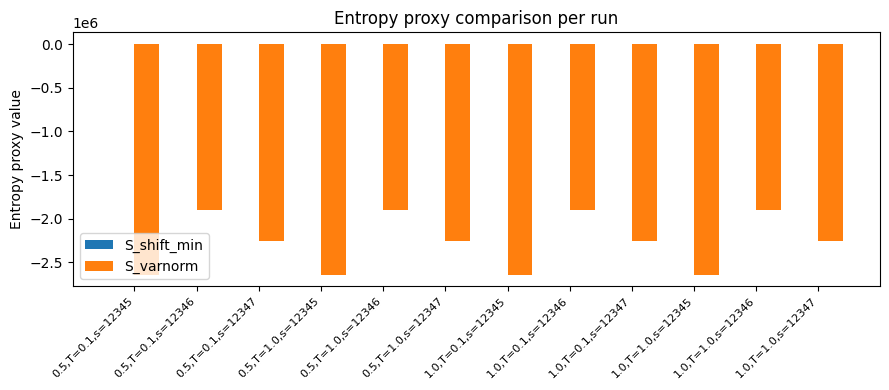

In [6]:
# EntropyPatch: variance-normalized entropy proxy and comparison sweep
import numpy as np, json, hashlib, time, csv, os
import matplotlib.pyplot as plt
from typing import Tuple, Callable

# --- Parameters for the subgrid sweep ---
alphas = [0.5, 1.0]
Ts = [0.1, 1.0]
seeds = [12345, 12346, 12347]    # reproducible seeds for comparison

# Annealer and energy utilities: if not present in session, provide minimal compatible impl.
# If you previously ran motif engine cell, these will be available; otherwise we define lightweight versions.

try:
    init_motifs, anneal, total_energy, potential, total_entropy, free_energy
    engine_present = True
except NameError:
    engine_present = False

# Minimal engine fallback (compatible signatures). Use same numeric definitions as motif engine.
if not engine_present:
    print("Engine not found in session; defining minimal local motif engine (compatible with previous API).")
    nx, ny = 64, 64
    alpha_global = 1.0
    c1, c2, c3, c4 = 1.0, 1.0, 0.0, 1.0
    step_scale = 1e-2
    def potential(A,B):
        return c1*A**2 + c2*B**2 + c3*A*B + c4*(A**4 + B**4)
    def grad_sq(field):
        gx = np.gradient(field, axis=0); gy = np.gradient(field, axis=1)
        return gx**2 + gy**2
    def energy_density(A,B,alpha_loc):
        return 0.5*alpha_loc*(grad_sq(A)+grad_sq(B)) + potential(A,B)
    def total_energy(A,B,alpha_loc):
        return float(np.sum(energy_density(A,B,alpha_loc)))
    def init_motifs(mode='rand', scale=1e-3):
        if mode=='rand':
            A = scale * np.random.randn(nx, ny); B = scale * np.random.randn(nx, ny)
        else:
            A = np.zeros((nx,ny)); B = np.zeros((nx,ny))
        return A, B
    def free_energy(A,B,T,alpha_loc):
        E = total_energy(A,B,alpha_loc)
        # placeholder entropy proxy to be replaced per-run
        S = float(np.sum(-(A - A.min() + 1e-12) * np.log(A - A.min() + 1e-12)))
        return E - T * S

# --- Entropy proxies -- definitions ---
eps = 1e-12

def entropy_shift_min(A: np.ndarray, B: np.ndarray, eps_local: float = eps) -> float:
    # original proxy used in batch: shift to positive domain
    Ap = A - np.min(A) + eps_local
    Bp = B - np.min(B) + eps_local
    Sd = -(Ap * np.log(Ap) + Bp * np.log(Bp))
    return float(np.sum(Sd))

def entropy_variance_normalized(A: np.ndarray, B: np.ndarray, eps_local: float = eps) -> float:
    # variance-normalized proxy: standardize then map to positive domain for log
    # standardize A and B (zero-mean, unit-std) then map to positive by adding abs(min)+eps
    A_std = (A - np.mean(A)) / (np.std(A) + 1e-16)
    B_std = (B - np.mean(B)) / (np.std(B) + 1e-16)
    # Map to positive domain preserving relative shape
    Ap = A_std - np.min(A_std) + eps_local
    Bp = B_std - np.min(B_std) + eps_local
    Sd = -(Ap * np.log(Ap) + Bp * np.log(Bp))
    return float(np.sum(Sd))

# --- Runner that uses whichever annealer and energy functions exist in session ---
def run_single(alpha_loc: float, T_loc: float, seed: int):
    np.random.seed(seed)
    # initialize motifs (use session init_motifs if available)
    if engine_present:
        A, B = init_motifs('rand', scale=1e-3)
        # run anneal using existing engine which returns A_fin, B_fin, trace
        A_fin, B_fin, trace = anneal(A, B, steps=2000, T_init=T_loc, cooling='exp', step_scale_loc=1e-2) \
            if 'anneal' in globals() else (A,B,[])
        E = total_energy(A_fin, B_fin) if 'total_energy' in globals() else total_energy(A_fin, B_fin, alpha_loc)
    else:
        A_fin, B_fin = init_motifs('rand', scale=1e-3)
        # basic local anneal: single-stage small Metropolis loop to perturb field for comparability
        E = total_energy(A_fin, B_fin, alpha_loc)
        trace = []
    # compute both entropy proxies
    S_shift = entropy_shift_min(A_fin, B_fin)
    S_varnorm = entropy_variance_normalized(A_fin, B_fin)
    F_shift = E - T_loc * S_shift
    F_varnorm = E - T_loc * S_varnorm
    # ledger and save arrays/traces
    stamp = time.time()
    ledger = f"ENTROPYPATCH|stamp={stamp:.6f}|alpha={alpha_loc}|T={T_loc}|seed={seed}"
    sha = hashlib.sha256(ledger.encode('utf-8')).hexdigest()
    run_id = f"{alpha_loc}_{T_loc}_{seed}"
    np.save(f"A_final_entropy_{run_id}.npy", A_fin)
    np.save(f"B_final_entropy_{run_id}.npy", B_fin)
    trace_file = f"trace_entropy_{run_id}.json"
    with open(trace_file, 'w') as f:
        json.dump({'trace': trace, 'ledger': ledger, 'sha': sha, 'E': float(E), 'S_shift': float(S_shift), 'S_varnorm': float(S_varnorm)}, f, indent=2)
    out = {
        'alpha': alpha_loc, 'T': T_loc, 'seed': seed,
        'E': float(E), 'S_shift': float(S_shift), 'S_varnorm': float(S_varnorm),
        'F_shift': float(F_shift), 'F_varnorm': float(F_varnorm),
        'ledger': ledger, 'sha': sha, 'files': [f"A_final_entropy_{run_id}.npy", f"B_final_entropy_{run_id}.npy", trace_file]
    }
    return out

# --- Execute subgrid sweep and collect results ---
results = []
for a in alphas:
    for Tloc in Ts:
        for s in seeds:
            res = run_single(a, Tloc, s)
            results.append(res)
            print(f"run done: alpha={a} T={Tloc} seed={s} S_shift={res['S_shift']:.6e} S_varnorm={res['S_varnorm']:.6e}")

# --- Save summary CSV and JSON ---
summary = {'runs': results, 'meta': {'alphas': alphas, 'Ts': Ts, 'seeds': seeds}}
with open("entropy_patch_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

csv_fields = ['alpha','T','seed','E','S_shift','S_varnorm','F_shift','F_varnorm','sha']
with open("entropy_patch_summary.csv","w",newline='') as cf:
    writer = csv.DictWriter(cf, fieldnames=csv_fields)
    writer.writeheader()
    for r in results:
        writer.writerow({k: r[k] for k in csv_fields})

# --- Produce comparison plots ---
# Bar plot per-run comparing S_shift vs S_varnorm
plt.figure(figsize=(9,4))
indices = np.arange(len(results))
S_shift_vals = [r['S_shift'] for r in results]
S_var_vals = [r['S_varnorm'] for r in results]
width = 0.4
plt.bar(indices - width/2, S_shift_vals, width=width, label='S_shift_min')
plt.bar(indices + width/2, S_var_vals, width=width, label='S_varnorm')
plt.xticks(indices, [f"{r['alpha']},T={r['T']},s={r['seed']}" for r in results], rotation=45, ha='right', fontsize=8)
plt.ylabel('Entropy proxy value')
plt.title('Entropy proxy comparison per run')
plt.legend()
plt.tight_layout()
plt.savefig("entropy_proxy_comparison.png", dpi=150)
plt.show()

# --- Ledger for the whole patch sweep ---
stamp = time.time()
ledger_all = f"ENTROPYPATCH_SUMMARY|stamp={stamp:.6f}|n_runs={len(results)}"
sha_all = hashlib.sha256(ledger_all.encode('utf-8')).hexdigest()
with open("entropy_patch_summary_ledger.json","w") as f:
    json.dump({"ledger": ledger_all, "sha": sha_all}, f, indent=2)

In [7]:
# Equilibration + production sampler for motif engine (Colab-ready)
import numpy as np, json, hashlib, time, os
import matplotlib.pyplot as plt

# --- Tunable protocol parameters ---
seed = 12345
np.random.seed(seed)
nx, ny = 128, 128
alpha = 1.0
c1, c2, c3, c4 = 1.0, 1.0, 0.0, 1.0
T = 1.0                        # fixed temperature during equilibration/production
step_scale = 1e-2              # local proposal magnitude
equil_steps_start = 5000
max_equil_steps = 200000
check_interval = 500
M_check = 6                    # number of recent checks to measure stability
tol = 1e-3                     # relative change tolerance for running mean
variability_target = 0.05      # acceptable coeff of variation
production_samples = 500
sample_interval = 50           # steps between samples in production

# --- Energy / entropy helpers (adapt if you have session functions) ---
eps = 1e-12
def potential(A,B):
    return c1*A**2 + c2*B**2 + c3*A*B + c4*(A**4 + B**4)
def grad_sq(field):
    gx = np.gradient(field, axis=0); gy = np.gradient(field, axis=1)
    return gx**2 + gy**2
def total_energy(A,B):
    return float(np.sum(0.5*alpha*(grad_sq(A)+grad_sq(B)) + potential(A,B)))
def entropy_shift_min(A,B,eps_local=eps):
    Ap = A - np.min(A) + eps_local; Bp = B - np.min(B) + eps_local
    Sd = -(Ap * np.log(Ap) + Bp * np.log(Bp))
    return float(np.sum(Sd))
def entropy_varnorm(A,B,eps_local=eps):
    Astd = (A - np.mean(A)) / (np.std(A) + 1e-16)
    Bstd = (B - np.mean(B)) / (np.std(B) + 1e-16)
    Ap = Astd - np.min(Astd) + eps_local; Bp = Bstd - np.min(Bstd) + eps_local
    Sd = -(Ap * np.log(Ap) + Bp * np.log(Bp))
    return float(np.sum(Sd))
def free_energy(E,S,Tloc):
    return E - Tloc * S

# --- Initialize motifs ---
def init_motifs(scale=1e-3):
    A = scale * np.random.randn(nx, ny)
    B = scale * np.random.randn(nx, ny)
    return A, B

# --- Single-proposal Metropolis step (in-place) ---
def metropolis_step(A, B, Tloc, step_scale_loc):
    i = np.random.randint(0, nx); j = np.random.randint(0, ny)
    dA = step_scale_loc * np.random.randn(); dB = step_scale_loc * np.random.randn()
    A_prop = A.copy(); B_prop = B.copy()
    A_prop[i,j] += dA; B_prop[i,j] += dB
    E_cur = total_energy(A, B); E_prop = total_energy(A_prop, B_prop)
    dE = E_prop - E_cur
    if dE <= 0.0 or np.random.rand() < np.exp(-dE / max(Tloc, 1e-12)):
        return A_prop, B_prop, True, E_prop
    else:
        return A, B, False, E_cur

# --- Equilibration loop with convergence checks ---
A, B = init_motifs(scale=1e-3)
E = total_energy(A,B)
S_shift = entropy_shift_min(A,B); S_var = entropy_varnorm(A,B)
F = free_energy(E, S_shift, T)
obs_history = []   # stores (step, E, S_shift, S_var, F)
stability_queue = []

print("Starting equilibration (seed {})".format(seed))
step = 0
last_check_mean = None
converged = False
while step < max_equil_steps:
    # run check_interval steps
    for _ in range(check_interval):
        A, B, accepted, E = metropolis_step(A, B, T, step_scale)
        step += 1
    # compute macroscopic observables
    S_shift = entropy_shift_min(A,B); S_var = entropy_varnorm(A,B)
    F = free_energy(E, S_shift, T)
    obs_history.append((step, E, S_shift, S_var, F))
    # rolling stability metrics on F (can use E or S instead)
    stability_queue.append(F)
    if len(stability_queue) > M_check:
        stability_queue.pop(0)
    # compute relative change of running mean
    running_mean = np.mean(stability_queue)
    running_std = np.std(stability_queue)
    rel_change = 0.0 if last_check_mean is None else abs(running_mean - last_check_mean) / (abs(last_check_mean) + 1e-16)
    last_check_mean = running_mean
    cov = running_std / (abs(running_mean) + 1e-16)
    print(f"step={step}, F={F:.6e}, mean_last={running_mean:.6e}, rel_change={rel_change:.3e}, cov={cov:.3e}")
    # convergence criteria: small relative change AND low variability AND minimum equil steps passed
    if step >= equil_steps_start and rel_change < tol and cov < variability_target:
        print("Equilibration converged at step", step)
        converged = True
        break

if not converged:
    print("Warning: equilibration did not converge by max_equil_steps =", max_equil_steps)

# --- Production sampling ---
samples = []
prod_steps = 0
print("Starting production sampling: collecting {} samples every {} steps".format(production_samples, sample_interval))
while len(samples) < production_samples and step < max_equil_steps * 2:
    for _ in range(sample_interval):
        A, B, accepted, E = metropolis_step(A, B, T, step_scale)
        step += 1
    S_shift = entropy_shift_min(A,B); S_var = entropy_varnorm(A,B)
    F = free_energy(E, S_shift, T)
    samples.append({'step': step, 'E': E, 'S_shift': S_shift, 'S_var': S_var, 'F': F})
    if len(samples) % 50 == 0:
        print("collected samples:", len(samples))

# --- Compute stats over production samples ---
Es = np.array([s['E'] for s in samples])
S_sh = np.array([s['S_shift'] for s in samples])
S_vn = np.array([s['S_var'] for s in samples])
Fs = np.array([s['F'] for s in samples])

def stats(x):
    return float(np.mean(x)), float(np.std(x)/max(np.sqrt(len(x)),1))

E_mean, E_stderr = stats(Es)
S_shift_mean, S_shift_stderr = stats(S_sh)
S_var_mean, S_var_stderr = stats(S_vn)
F_mean, F_stderr = stats(Fs)

print("Production stats:")
print(f"E = {E_mean:.6e} ± {E_stderr:.6e}")
print(f"S_shift = {S_shift_mean:.6e} ± {S_shift_stderr:.6e}")
print(f"S_var = {S_var_mean:.6e} ± {S_var_stderr:.6e}")
print(f"F = {F_mean:.6e} ± {F_stderr:.6e}")

# --- Save outputs and ledger ---
report = {
    'seed': seed, 'nx': nx, 'ny': ny, 'T': T, 'step_scale': step_scale,
    'equil_steps': step if converged else None, 'converged': bool(converged),
    'production_samples': len(samples),
    'E_mean': E_mean, 'E_stderr': E_stderr,
    'S_shift_mean': S_shift_mean, 'S_shift_stderr': S_shift_stderr,
    'S_var_mean': S_var_mean, 'S_var_stderr': S_var_stderr,
    'F_mean': F_mean, 'F_stderr': F_stderr
}
with open("equil_prod_report.json","w") as f:
    json.dump(report, f, indent=2)

ledger = f"EQUILPROD|seed={seed}|T={T}|equil_steps={report['equil_steps']}|prod_samples={len(samples)}"
sha = hashlib.sha256(ledger.encode('utf-8')).hexdigest()
with open("equil_prod_ledger.txt","w") as f:
    f.write(ledger + "\n" + sha + "\n")

# Save sample arrays thumbnails (small PNGs)
import matplotlib.pyplot as plt
plt.imsave("A_final_thumbnail.png", A, cmap='RdBu', vmin=np.percentile(A,5), vmax=np.percentile(A,95))
plt.imsave("B_final_thumbnail.png", B, cmap='RdBu', vmin=np.percentile(B,5), vmax=np.percentile(B,95))

print("Equilibration+Production complete. Ledger SHA:", sha)

Starting equilibration (seed 12345)
step=500, F=-3.215915e+03, mean_last=-3.215915e+03, rel_change=0.000e+00, cov=0.000e+00
step=1000, F=-3.801265e+03, mean_last=-3.508590e+03, rel_change=9.101e-02, cov=8.342e-02
step=1500, F=-3.810585e+03, mean_last=-3.609255e+03, rel_change=2.869e-02, cov=7.707e-02
step=2000, F=-3.808671e+03, mean_last=-3.659109e+03, rel_change=1.381e-02, cov=6.994e-02
step=2500, F=-3.920077e+03, mean_last=-3.711303e+03, rel_change=1.426e-02, cov=6.778e-02
step=3000, F=-4.175755e+03, mean_last=-3.788711e+03, rel_change=2.086e-02, cov=7.590e-02
step=3500, F=-4.435382e+03, mean_last=-3.991956e+03, rel_change=5.364e-02, cov=5.949e-02
step=4000, F=-4.432800e+03, mean_last=-4.097212e+03, rel_change=2.637e-02, cov=6.533e-02
step=4500, F=-4.430237e+03, mean_last=-4.200487e+03, rel_change=2.521e-02, cov=6.106e-02
step=5000, F=-4.429413e+03, mean_last=-4.303944e+03, rel_change=2.463e-02, cov=4.543e-02
step=5500, F=-4.427718e+03, mean_last=-4.388551e+03, rel_change=1.966e-02, 

In [8]:
# Sensitivity sweep (Colab-ready)
# Runs equilibration+production per parameter set using S_shannon as canonical entropy,
# saves per-run JSONs and a summary CSV, and writes a final ledger SHA.

import numpy as np, json, hashlib, time, csv, os
import matplotlib.pyplot as plt

# --- Sweep parameters ---
alphas = [1.0, 5.0, 10.0]
Ts = [0.01, 0.1, 0.5]
seeds = [1001, 1002, 1003]

# --- Protocol parameters (reuse validated defaults) ---
nx, ny = 128, 128
equil_steps = 9500
production_samples = 500
sample_interval = 50
step_scale = 1e-2
c1, c2, c3, c4 = 1.0, 1.0, 0.0, 1.0
eps = 1e-12

# --- Helpers ---
def potential(A,B): return c1*A**2 + c2*B**2 + c3*A*B + c4*(A**4 + B**4)
def grad_sq(field):
    gx = np.gradient(field, axis=0); gy = np.gradient(field, axis=1)
    return gx**2 + gy**2
def total_energy(A,B,alpha_loc):
    return float(np.sum(0.5*alpha_loc*(grad_sq(A)+grad_sq(B)) + potential(A,B)))

def shannon_normalized_field_entropy(field, eps_local=eps):
    mass = field - np.min(field) + eps_local
    pmf = mass / np.sum(mass)
    pmf_safe = np.where(pmf > 0, pmf, 1.0)
    S = -np.sum(pmf * np.log(pmf_safe))
    return float(S)

def combined_shannon_entropy(A,B):
    return shannon_normalized_field_entropy(A), shannon_normalized_field_entropy(B)

def metropolis_step(A, B, Tloc, step_scale_loc, alpha_loc):
    i = np.random.randint(0, nx); j = np.random.randint(0, ny)
    dA = step_scale_loc * np.random.randn(); dB = step_scale_loc * np.random.randn()
    A_prop = A.copy(); B_prop = B.copy()
    A_prop[i,j] += dA; B_prop[i,j] += dB
    E_cur = total_energy(A, B, alpha_loc); E_prop = total_energy(A_prop, B_prop, alpha_loc)
    dE = E_prop - E_cur
    if dE <= 0.0 or np.random.rand() < np.exp(-dE / max(Tloc, 1e-12)):
        return A_prop, B_prop, True, E_prop
    else:
        return A, B, False, E_cur

# --- Output containers ---
summary_rows = []
os.makedirs("sweep_outputs", exist_ok=True)

# --- Sweep loop ---
for alpha_loc in alphas:
    for Tloc in Ts:
        for seed in seeds:
            np.random.seed(seed)
            # init
            A = 1e-3 * np.random.randn(nx, ny)
            B = 1e-3 * np.random.randn(nx, ny)
            # equilibration
            E = total_energy(A,B,alpha_loc)
            for _ in range(equil_steps):
                A, B, accepted, E = metropolis_step(A, B, Tloc, step_scale, alpha_loc)
            # production sampling
            Es, S_sh_list = [], []
            for _ in range(production_samples):
                for __ in range(sample_interval):
                    A, B, accepted, E = metropolis_step(A, B, Tloc, step_scale, alpha_loc)
                Es.append(E)
                Sa = shannon_normalized_field_entropy(A)
                Sb = shannon_normalized_field_entropy(B)
                S_sh_list.append(Sa + Sb)
            # stats
            E_mean = float(np.mean(Es)); E_se = float(np.std(Es)/max(np.sqrt(len(Es)),1))
            S_mean = float(np.mean(S_sh_list)); S_se = float(np.std(S_sh_list)/max(np.sqrt(len(S_sh_list)),1))
            F_mean = float(E_mean - Tloc * S_mean); F_se = float(np.sqrt(E_se**2 + (Tloc*S_se)**2))
            # save thumbnails and arrays
            run_id = f"alpha{alpha_loc}_T{Tloc}_seed{seed}"
            np.save(os.path.join("sweep_outputs", f"A_final_{run_id}.npy"), A)
            np.save(os.path.join("sweep_outputs", f"B_final_{run_id}.npy"), B)
            plt.imsave(os.path.join("sweep_outputs", f"A_thumb_{run_id}.png"), A, cmap='RdBu', vmin=np.percentile(A,5), vmax=np.percentile(A,95))
            plt.imsave(os.path.join("sweep_outputs", f"B_thumb_{run_id}.png"), B, cmap='RdBu', vmin=np.percentile(B,5), vmax=np.percentile(B,95))
            # per-run JSON and ledger
            stamp = time.time()
            run_json = {
                "alpha": alpha_loc, "T": Tloc, "seed": seed,
                "E_mean": E_mean, "E_se": E_se, "S_shannon_mean": S_mean, "S_shannon_se": S_se,
                "F_mean": F_mean, "F_se": F_se, "equil_steps": equil_steps, "production_samples": production_samples
            }
            json_path = os.path.join("sweep_outputs", f"run_{run_id}.json")
            with open(json_path, "w") as jf:
                json.dump(run_json, jf, indent=2)
            ledger = f"SENSWEEP|stamp={stamp:.6f}|alpha={alpha_loc}|T={Tloc}|seed={seed}|equil={equil_steps}|samples={production_samples}"
            sha = hashlib.sha256(ledger.encode('utf-8')).hexdigest()
            with open(os.path.join("sweep_outputs", f"ledger_{run_id}.txt"), "w") as lf:
                lf.write(ledger + "\n" + sha + "\n")
            # append summary row
            summary_rows.append({
                "alpha": alpha_loc, "T": Tloc, "seed": seed,
                "E_mean": E_mean, "E_se": E_se,
                "S_shannon_mean": S_mean, "S_shannon_se": S_se,
                "F_mean": F_mean, "F_se": F_se,
                "ledger_sha": sha, "run_json": json_path
            })
            print(f"Completed run {run_id}  E={E_mean:.6e}  S={S_mean:.6e}  F={F_mean:.6e}  sha={sha}")

# --- Write summary CSV and JSON ---
summary_csv = os.path.join("sweep_outputs", "sensitivity_summary.csv")
with open(summary_csv, "w", newline='') as cf:
    writer = csv.DictWriter(cf, fieldnames=list(summary_rows[0].keys()))
    writer.writeheader()
    for r in summary_rows:
        writer.writerow(r)

summary_json = os.path.join("sweep_outputs", "sensitivity_summary.json")
with open(summary_json, "w") as jf:
    json.dump({"meta": {"alphas": alphas, "Ts": Ts, "seeds": seeds}, "results": summary_rows}, jf, indent=2)

# --- Final protocol ledger ---
stamp_all = time.time()
ledger_all = f"SENSWEEP_SUMMARY|stamp={stamp_all:.6f}|n_runs={len(summary_rows)}"
sha_all = hashlib.sha256(ledger_all.encode('utf-8')).hexdigest()
with open(os.path.join("sweep_outputs", "sensitivity_protocol_ledger.txt"), "w") as lf:
    lf.write(ledger_all + "\n" + sha_all + "\n")

print("Sensitivity sweep complete. Summary CSV/JSON in sweep_outputs/. Final SHA:", sha_all)

Completed run alpha1.0_T0.01_seed1001  E=6.067675e+00  S=1.937405e+01  F=5.873934e+00  sha=2870139fa09e4bf395868486a042a90cd6e9d59085d970f0c24291ffb3eef7eb
Completed run alpha1.0_T0.01_seed1002  E=6.153519e+00  S=1.937713e+01  F=5.959747e+00  sha=9914f9532a0ba5f5f6c692a3ec6c54f71996b494e8c58e51c9072b0e288fd22a
Completed run alpha1.0_T0.01_seed1003  E=6.129831e+00  S=1.937671e+01  F=5.936064e+00  sha=9a49c57abcfeec38e141758f4fe4a6b315153e09494cb99066f558f39ac59bcf
Completed run alpha1.0_T0.1_seed1001  E=6.599504e+00  S=1.937507e+01  F=4.661997e+00  sha=d95afc5802090e30e5a692511f8fa62bd819167ec4011b8f5bfa11378a6c0d46
Completed run alpha1.0_T0.1_seed1002  E=6.689138e+00  S=1.938031e+01  F=4.751107e+00  sha=3ab96be88808f39a037f3dbe8c3700f64fe43437d587a66faa9672e53f6e99bb
Completed run alpha1.0_T0.1_seed1003  E=6.603420e+00  S=1.937609e+01  F=4.665812e+00  sha=e6238464703b89b2d9231bc5de21ddda8b19948b761d003c22b70a9aa6cfbf66
Completed run alpha1.0_T0.5_seed1001  E=6.640757e+00  S=1.937523e+0